# **Step 1: Importing the Relevant Libraries**

In [5]:
!pip install transformers

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image
import spacy
# import en_core_web_sm

import random
import warnings
import time
import datetime

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **Step 2: Configurations**

In [7]:
#Setting seeds for consistent results.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [8]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available. {}'.format(torch.cuda.device_count()))
    print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))

# If we dont have GPU but a CPU, training will take place on CPU instead
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are %d GPU(s) available. 1
We will use the GPU: Tesla K80


# **Step 3: Data Inspection**

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [10]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [12]:
train.shape,test.shape

((20800, 5), (5200, 4))

In [13]:
train.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Target Count')

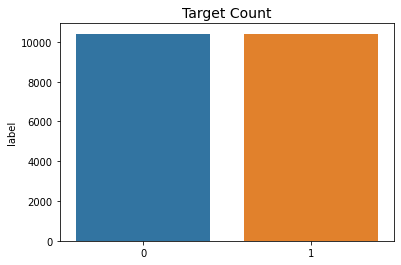

In [14]:
label = train["label"].value_counts()
sns.barplot(label.index, label)
plt.title('Target Count', fontsize=14)

it is a balanced dataset

In [15]:
#ratio of null values
train.isnull().sum()/train.shape[0] *100

id        0.000000
title     2.682692
author    9.408654
text      0.187500
label     0.000000
dtype: float64

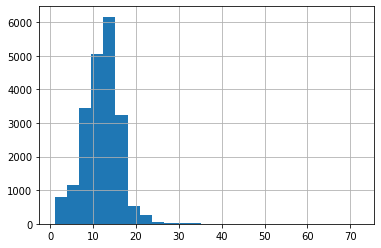

In [16]:
seq_len_premise = [len(str(i).split()) for i in train['title']]

pd.Series(seq_len_premise).hist(bins = 25)

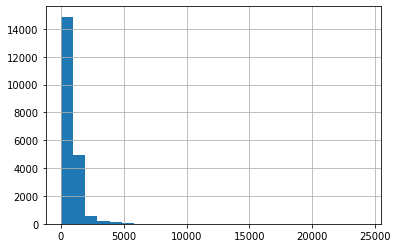

In [17]:
seq_len_premise = [len(str(i).split()) for i in train['text']]
pd.Series(seq_len_premise).hist(bins = 25)

In [18]:
print(sum(seq_len_premise)/len(seq_len_premise))

758.8844230769231


# **Step 4: Data Cleaning**

In [19]:
print(train.isna().sum(),'\n')
print(train.dropna(how='all').isna().sum())

id           0
title      558
author    1957
text        39
label        0
dtype: int64 

id           0
title      558
author    1957
text        39
label        0
dtype: int64


In [20]:
train.shape

(20800, 5)

In [21]:
train = train.fillna('none mentioned')
test = test.fillna('none mentioned')

In [22]:
def text_cleaning(text):
    text = str(text)
    text = re.sub("[^a-zA-Z]", " ", text) # removing punctuation
    # remove special characters from text column
    text = re.sub('[#,@,&]', '',text)
    # Remove digits
    text = re.sub('\d*','', text)
    #Remove www
    text = re.sub('w{3}','', text)
    # remove urls
    text = re.sub("http\S+", "", text)
    # remove multiple spaces with single space
    text = re.sub('\s+', ' ', text)
    #remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', '', text)

    return text

In [23]:
train['text']=train['text'].apply(text_cleaning)
train['title']=train['title'].apply(text_cleaning)

test['text']=test['text'].apply(text_cleaning)
test['title']=test['title'].apply(text_cleaning)


In [24]:
stop_words = stopwords.words('english')

train['text'] = train['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test['text'] = test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

train['title'] = train['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test['title'] = test['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [25]:
# print(f'Number of training tweets: {train.shape[0]}\n')
# print(f'Number of training tweets: {test.shape[0]}\n')

In [26]:
labels = train['label'].values

In [27]:
#case
train_data = (train['title'] + ' ' + train['author']).values
test_data = (test['title'] + ' ' + test['author']).values

In [28]:
# train_data = (train['title'] + ' ' + train['author'] + ' ' + train['text']).values
# test_data = (test['title'] + ' ' + test['author'] + ' ' + test['text']).values

# **Step 4: Initializing the model**

**4.1 Tokenization**

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # Use the 124-layer, 1024-hidden, 16-heads, 340M parameters BERT model with an uncased vocab.
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False, 
)
model.to(device)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [31]:
print(' Original: ', train_data[0])
print('Tokenized: ', tokenizer.tokenize(train_data[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0])))

 Original:  House Dem Aide We DidnEven See ComeyLetter Until Jason Chaffetz Tweeted It Darrell Lucus
Tokenized:  ['house', 'dem', 'aide', 'we', 'didn', '##eve', '##n', 'see', 'come', '##yle', '##tter', 'until', 'jason', 'cha', '##ffe', '##tz', 't', '##wee', '##ted', 'it', 'darrell', 'luc', '##us']
Token IDs:  [2160, 17183, 14895, 2057, 2134, 18697, 2078, 2156, 2272, 12844, 12079, 2127, 4463, 15775, 16020, 5753, 1056, 28394, 3064, 2009, 23158, 12776, 2271]


In [32]:
train_data

array(['House Dem Aide We DidnEven See ComeyLetter Until Jason Chaffetz Tweeted It Darrell Lucus',
       'FLYNN Hillary Clinton Big Woman Campus Breitbart Daniel J. Flynn',
       'Why Truth Might Get You Fired Consortiumnews.com', ...,
       'MacyIs Said Receive Takeover Approach HudsonBay The New York Times Michael J. de la Merced and Rachel Abrams',
       'NATO Russia To Hold Parallel Exercises In Balkans Alex Ansary',
       'What Keeps theAlive David Swanson'], dtype=object)

In [33]:
max_len = 0
id_len = []
for text in train_data:    
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    id_len.append(len(input_ids))
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  87


since 651>512 , hence need to set max length

In [34]:
max(id_len)

87

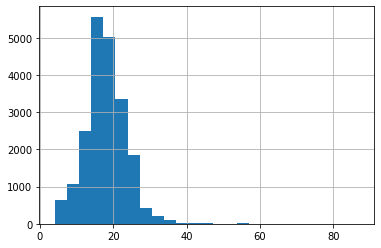

In [35]:
pd.Series(id_len).hist(bins = 25)

we can say max_length = *84*

In [36]:
max_length = 84

In [37]:
max_len = 0
for text in test_data:    
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  94


In [38]:
train_data.shape, test_data.shape

((20800,), (5200,))

In [39]:
def tokenize_map(sentence,labs='None'):
    
    """A function for tokenize all of the sentences and map the tokens to their word IDs."""
    
    global labels
    input_ids = []
    attention_masks = []
    for text in sentence:  
        encoded_dict = tokenizer.encode_plus(
                            text,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            truncation='longest_first', # Activate and control truncation
                            max_length = max_length,           # Max length according to our text data.
                            pad_to_max_length = True, # Pad & truncate all sentences.
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )    
        input_ids.append(encoded_dict['input_ids'])     
        attention_masks.append(encoded_dict['attention_mask'])   
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)   
    if labs != 'None': # Setting this for using this definition for both train and test data so labels won't be a problem in our outputs.
        labels = torch.tensor(labels)
        return input_ids, attention_masks, labels
    else:
        return input_ids, attention_masks

In [40]:
input_ids, attention_masks, labels = tokenize_map(train_data, labels)
test_input_ids, test_attention_masks= tokenize_map(test_data)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


**4.2 Train Validatopn split**

In [41]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [42]:
train_size, val_size

(16640, 4160)

**4.3 DataLoaders**

In [43]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
)

In [44]:
prediction_data = TensorDataset(test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

**4.4 Optimizer & Learning Rate Scheduler**

In [45]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon
                )

In [46]:
epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [47]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return accuracy_score(labels_flat, pred_flat)

def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # print("pred_flat ", pred_flat)
    # print("labels_flat", labels_flat)
    
    # print("for 0: ",f1_score(labels_flat, pred_flat, pos_label=0))
    # print("for 1: ",f1_score(labels_flat, pred_flat, pos_label=1))
    return f1_score(labels_flat, pred_flat)

In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
def format_time(elapsed):    
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# **Step 5: Training and Validation**

In [50]:
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print('')
    print('Training...')
    print('----- Epoch {:} / {:} -----'.format(epoch_i + 1, epochs))

    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0) 
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device).to(torch.int64)
        b_input_mask = batch[1].to(device).to(torch.int64)
        b_labels = batch[2].to(device).to(torch.int64)
        
        model.zero_grad()        

        loss = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[0]
        logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[1]

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print('')
    print('  Average training loss: {0:.2f}'.format(avg_train_loss))
    print('  Training epoc h took: {:}'.format(training_time))


Training...
----- Epoch 1 / 2 -----
  Batch    40  of    520.    Elapsed: 0:00:49.
  Batch    80  of    520.    Elapsed: 0:01:39.
  Batch   120  of    520.    Elapsed: 0:02:28.
  Batch   160  of    520.    Elapsed: 0:03:17.
  Batch   200  of    520.    Elapsed: 0:04:06.
  Batch   240  of    520.    Elapsed: 0:04:55.
  Batch   280  of    520.    Elapsed: 0:05:44.
  Batch   320  of    520.    Elapsed: 0:06:32.
  Batch   360  of    520.    Elapsed: 0:07:21.
  Batch   400  of    520.    Elapsed: 0:08:10.
  Batch   440  of    520.    Elapsed: 0:08:59.
  Batch   480  of    520.    Elapsed: 0:09:47.

  Average training loss: 0.16
  Training epoc h took: 0:10:36

Training...
----- Epoch 2 / 2 -----
  Batch    40  of    520.    Elapsed: 0:00:48.
  Batch    80  of    520.    Elapsed: 0:01:37.
  Batch   120  of    520.    Elapsed: 0:02:26.
  Batch   160  of    520.    Elapsed: 0:03:14.
  Batch   200  of    520.    Elapsed: 0:04:03.
  Batch   240  of    520.    Elapsed: 0:04:52.
  Batch   280  of

In [51]:
training_stats = []
validations_labels_ep = []
actual_labels_ep = []
actual = np.zeros(shape=(0,0))
total_t0 = time.time()
for epoch_i in range(0, epochs):
    print('')
    print('Validation...')

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    total_eval_f1 = 0
    nb_eval_steps = 0
    
    validations = []
    
    validations_labels = []
    actual_labels = []

    for step, batch in enumerate(validation_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
    
        with torch.no_grad():        
            loss = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[0]

            logits = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)[1]
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        if(epoch_i == epochs-1):
          actual = np.append(actual, label_ids)
          validations.append(logits)

        # print("shape ",actual.flatten().shape)        

        if(step == len(validation_dataloader)-1 and epoch_i == epochs-1):
          flat_validations = [item for sublist in validations for item in sublist]
          flat_validations = np.argmax(flat_validations, axis=1).flatten()
          validations_labels.append(flat_validations)

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        total_eval_f1 += flat_f1(logits, label_ids)

    validations_labels_ep.append(validations_labels)
    actual_labels_ep.append(actual_labels)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print('  Accuracy: {0:.2f}'.format(avg_val_accuracy))

    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print('  F1: {0:.2f}'.format(avg_val_f1))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print('  Validation Loss: {0:.2f}'.format(avg_val_loss))
    print('  Validation took: {:}'.format(validation_time))

    training_stats.append(
        {
            'EPOCH': epoch_i + 1,
            'Train. Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Valid. F1' : avg_val_f1,
            'Train. Time': training_time,
            'Valid. Time': validation_time
        }
    )

print('')
print('Total training took {:} (h:mm:ss)'.format(format_time(time.time()-total_t0)))


Validation...
  Accuracy: 0.99
  F1: 0.99
  Validation Loss: 0.05
  Validation took: 0:01:22

Validation...
  Accuracy: 0.99
  F1: 0.99
  Validation Loss: 0.05
  Validation took: 0:01:22

Total training took 0:02:44 (h:mm:ss)


# **Step 5: Evaluation**

Using Title and Author name

In [52]:
pd.set_option('precision', 3)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('EPOCH')
display(df_stats)

,Train. Loss,Valid. Loss,Valid. Accur.,Valid. F1,Train. Time,Valid. Time
EPOCH,,,,,,
1,0.046,0.046,0.988,0.987,0:10:33,0:01:22
2,0.046,0.046,0.988,0.987,0:10:33,0:01:22


In [53]:
orig = validations_labels_ep[1][0].tolist()
pred = [round(x) for x in actual.tolist()]

In [54]:
cm = confusion_matrix(orig, pred, labels=[0,1])

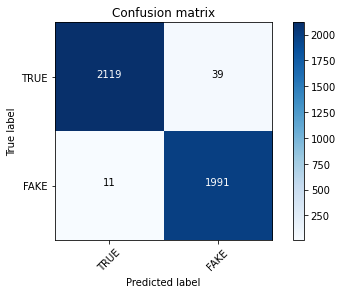

In [55]:
plot_confusion_matrix(cm, classes=['TRUE','FAKE'], title ='Confusion matrix')

In [56]:
# # type(validations_labels_ep[1][0])
# print(validations_labels_ep[1][0].tolist())

In [57]:
class_based = []
class_based.append(
        {
            'class': 0,
            'f1_score': f1_score(orig, pred, pos_label=0),
            'precision_score': precision_score(orig, pred, pos_label=0),
            'recall_score': precision_score(orig, pred, pos_label=0),
        }
    )
class_based.append(
        {
            'class': 1,
            'f1_score': f1_score(orig, pred, pos_label=1),
            'precision_score': precision_score(orig, pred, pos_label=1),
            'recall_score': precision_score(orig, pred, pos_label=1),
        }
    )

In [58]:
pd.set_option('precision', 3)
df_stats = pd.DataFrame(data=class_based)
df_stats = df_stats.set_index('class')
display(df_stats)

,f1_score,precision_score,recall_score
class,,,
0,0.988,0.995,0.995
1,0.988,0.981,0.981


**5.1 Test Data**

In [59]:
print('Predicting label len'.format(len(test_input_ids)))

model.eval()

predictions = []

for batch in prediction_dataloader:
  
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
  
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
 
  predictions.append(logits)

Predicting label len


**Submission**

In [60]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

In [61]:
submission1 = pd.read_csv('submit.csv')
submission1['label'] = flat_predictions
submission1.head(10)

,id,label
0,20800,0
1,20801,1
2,20802,1
3,20803,0
4,20804,1
5,20805,1
6,20806,0
7,20807,1
8,20808,1
9,20809,1


In [62]:
submission1.to_csv('submission1.csv', index= False)